.ipynb settings

In [7]:
#Settings relative to .ipynb file format that have to be executed here

#Make reloading of modules automatic et évite d'avoir à redémarer le kernel et tout re executer pour appliquer la modification d'un module dans __main__.
%load_ext autoreload  
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#src.useful_functions
import sys
sys.path.append('../src')  # Adjust the path to import modules in src/

import useful_functions

Importation of the dataset(s)

In [9]:
#Importing dataset(s)
from data import make_dataset

#Load the train and test datasets:
X_train_00   = make_dataset.load_data(False, 'processed/split/X_train_00')
Y_train_00   = make_dataset.load_data(False, 'processed/split/Y_train_00')
X_test_00 = make_dataset.load_data(False, 'processed/split/X_test_00')
Y_test_00 = make_dataset.load_data(False, 'processed/split/Y_test_00')


#Load the not_split train and test datasets:
X   = make_dataset.load_data(False, 'processed/not_split/X')
Y   = make_dataset.load_data(False, 'processed/not_split/Y')
X_info = make_dataset.load_data(False, 'processed/not_split/X_info')


# VI) <u> Pipeline development 

<span style="color:#FF1493;"> <strong> <font size="4">1) Logistic Regression Pipeline and GridSearchCV implementation

In [10]:

# --------------------------------------------------------------
# Correlated features remover (not used)
# --------------------------------------------------------------

from features import features_selection
from configuration import constant_variables
from dvclive import Live


# Correlated features remover definition (it's a transformer)
# corr_features_selector = features_selection.correlated_features_removal_transformer(corr_threshold = 0.95)


# --------------------------------------------------------------
# Features selector
# --------------------------------------------------------------

"""
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model_sfs = LogisticRegression(max_iter=10000, C = 0.3, random_state =33, penalty = 'l2')
sequ_feat_selector = SFS(estimator = model_sfs, k_features = 'best', forward = True, verbose = 0, cv=constant_variables.CV, scoring = 'neg_log_loss', n_jobs = -1)
"""

#OU

#Filter features selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
filter_feat_selector = SelectKBest(f_classif, k= 10)

# --------------------------------------------------------------
# Scaler
# --------------------------------------------------------------

from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = StandardScaler()


# --------------------------------------------------------------
# Model
# --------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'l1', fit_intercept=True, random_state = 999, solver = 'saga', max_iter= 3000, verbose = False, tol=1e-4)

# --------------------------------------------------------------
# Pipeline
# --------------------------------------------------------------
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[("scaler",scaler), ("features_selector",filter_feat_selector), ("model", model)])


#parameters to optimize definition
import numpy as np
parameters = {'model__penalty': ['l1', 'l2', 'elasticnet', 'None'],
             'model__C': np.logspace(-3, 1, 21),
             'model__solver': ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs'],
             'features_selector__k' : [13]
             }

# --------------------------------------------------------------
# GridSearchCV
# --------------------------------------------------------------
# Create a GridSearchCV object
from sklearn.model_selection import GridSearchCV
from configuration import constant_variables

grid_search = GridSearchCV(pipeline, parameters, cv=constant_variables.CV, scoring = 'neg_log_loss', verbose=0)
# Fit the GridSearchCV to the data
grid_search.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())




c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1365 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mb

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('features_selector', SelectKBest()),
                                       ('model',
                                        LogisticRegression(max_iter=3000,
                                                           penalty='l1',
                                                           random_state=999,
                                                           solver='saga',
                                                           verbose=False))]),
             param_grid={'features_selector__k': [13],
                         'model__C': array([1.00000000e-03, 1.58489319...
       6.30957344e-03, 1.00000000e-02, 1.58489319e-02, 2.51188643e-02,
       3.98107171e-02, 6.30957344e-02, 1.00000000e-01, 1.58489319e-01,
       2.51188643e-01, 3.98107171e-01, 6.30957344e-01, 1.00000000e+00,
       1.58489319e+00, 2.51188643e+00, 3.98107171e+00, 6.30957344e+00,
       1.00000000e+01]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'model__solver': ['saga', 'sag', 'liblinear',
                                           'newton-cg', 'lbfgs']},
             scoring='neg_log_loss')

<span style="color:#FF1493;"> <strong> <font size="4">2) Neural Network Pipeline and GridSearchCV optimisation

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_score, recall_score
import warnings

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2

warnings.filterwarnings("ignore", category=UserWarning)

# --------------------------------------------------------------------
# 1) Fonction de création du NN, avec argument input_dim
# --------------------------------------------------------------------
def create_nn_model_NN(
    input_dim=None,          # <-- scikeras passera input_dim ici
    optimizer='adam',
    activation='relu',
    neurons=32,
    layers=2,
    regularizer=None,
    dropout_rate=0.0,
):
    """
    input_dim : nombre de features. Peut être None => Keras infère si possible,
    mais scikeras essaie souvent de passer un input_dim != None.
    """
    model = Sequential()

    # Première couche
    if input_dim is not None:
        # scikeras a passé un input_dim => on l'utilise explicitement
        model.add(Dense(neurons, activation=activation,
                        kernel_regularizer=regularizer,
                        input_dim=input_dim))
    else:
        # pas d'input_dim => Keras l'infèrera si possible
        model.add(Dense(neurons, activation=activation,
                        kernel_regularizer=regularizer))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # couches cachées suivantes
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation=activation,
                        kernel_regularizer=regularizer))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # couche de sortie
    model.add(Dense(1, activation='sigmoid'))

    # compilation
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model


# --------------------------------------------------------------------
# 2) KerasClassifier scikeras
# --------------------------------------------------------------------
nn_wrapper = KerasClassifier(
    model=create_nn_model_NN,    # wrapper de la fonction
    # hyperparamètres par défaut
    optimizer="adam",
    activation="relu",
    neurons=32,
    layers=2,
    regularizer=None,
    dropout_rate=0.0,
    verbose=0,
    warm_start=False  # reconstruit le modèle à chaque fit
)

# --------------------------------------------------------------------
# 3) Pipeline
# --------------------------------------------------------------------
pipeline_NN = Pipeline([
    ("scaler", StandardScaler()),
    ("features_selector", SelectKBest(f_classif)),
    ("model", nn_wrapper)
])

# --------------------------------------------------------------------
# 4) Grille de paramètres
#    Noter qu'on NE met PAS input_dim dans la grille
# --------------------------------------------------------------------
parameters_NN = {
    'features_selector__k': [6, 11, 13, 16],
    'model__model__optimizer': ['adam', 'rmsprop'],
    'model__model__activation': ['relu', 'tanh'],
    'model__model__neurons': [16, 64],
    'model__model__layers': [2, 3],
    'model__model__regularizer': [None, l1(0.01), l2(0.01)],
    'model__model__dropout_rate': [0.0, 0.3]
}

grid_search_NN = GridSearchCV(
    pipeline_NN,
    parameters_NN,
    cv=3,
    scoring='neg_log_loss',
    verbose=1
)

# --------------------------------------------------------------------
# 5) Entraînement
# --------------------------------------------------------------------
grid_search_NN.fit(X_train_00, Y_train_00)

# --------------------------------------------------------------------
# 6) Résultats
# --------------------------------------------------------------------
print("Best Parameters:", grid_search_NN.best_params_)
print("Best Score:", grid_search_NN.best_score_)



c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The KerasClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


Fitting 3 folds for each of 384 candidates, totalling 1152 fits


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The KerasClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The KerasClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.

ValueError: 
All the 1152 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential' has no defined outputs yet.. Did you mean: 'output'?

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_4' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_5' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_9' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_10' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_11' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_12' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_13' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_14' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_15' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_16' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_17' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_18' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_19' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_20' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_21' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_22' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_23' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_24' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_25' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_26' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_27' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_28' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_29' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_30' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_31' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_32' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_33' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_34' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_35' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_36' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_37' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_38' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_39' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_40' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_41' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_42' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_43' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_44' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_45' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_46' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_47' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_48' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_49' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_50' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_51' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_52' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_53' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_54' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_55' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_56' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_57' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_58' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_59' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_60' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_61' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_62' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_63' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_64' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_65' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_66' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_67' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_68' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_69' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_70' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_71' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_72' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_73' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_74' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_75' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_76' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_77' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_78' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_79' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_80' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_81' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_82' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_83' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_84' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_85' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_86' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_87' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_88' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_89' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_90' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_91' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_92' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_93' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_94' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_95' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_96' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_97' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_98' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_99' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_100' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_101' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_102' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_103' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_104' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_105' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_106' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_107' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_108' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_109' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_110' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_111' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_112' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_113' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_114' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_115' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_116' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_117' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_118' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_119' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_120' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_121' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_122' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_123' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_124' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_125' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_126' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_127' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_128' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_129' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_130' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_131' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_132' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_133' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_134' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_135' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_136' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_137' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_138' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_139' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_140' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_141' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_142' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_143' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_144' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_145' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_146' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_147' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_148' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_149' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_150' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_151' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_152' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_153' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_154' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_155' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_156' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_157' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_158' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_159' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_160' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_161' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_162' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_163' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_164' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_165' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_166' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_167' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_168' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_169' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_170' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_171' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_172' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_173' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_174' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_175' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_176' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_177' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_178' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_179' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_180' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_181' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_182' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_183' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_184' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_185' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_186' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_187' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_188' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_189' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_190' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_191' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_192' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_193' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_194' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_195' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_196' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_197' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_198' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_199' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_200' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_201' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_202' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_203' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_204' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_205' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_206' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_207' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_208' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_209' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_210' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_211' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_212' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_213' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_214' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_215' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_216' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_217' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_218' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_219' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_220' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_221' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_222' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_223' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_224' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_225' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_226' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_227' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_228' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_229' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_230' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_231' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_232' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_233' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_234' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_235' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_236' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_237' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_238' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_239' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_240' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_241' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_242' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_243' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_244' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_245' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_246' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_247' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_248' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_249' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_250' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_251' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_252' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_253' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_254' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_255' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_256' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_257' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_258' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_259' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_260' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_261' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_262' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_263' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_264' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_265' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_266' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_267' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_268' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_269' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_270' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_271' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_272' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_273' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_274' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_275' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_276' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_277' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_278' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_279' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_280' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_281' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_282' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_283' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_284' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_285' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_286' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_287' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_288' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_289' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_290' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_291' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_292' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_293' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_294' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_295' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_296' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_297' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_298' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_299' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_300' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_301' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_302' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_303' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_304' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_305' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_306' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_307' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_308' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_309' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_310' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_311' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_312' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_313' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_314' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_315' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_316' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_317' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_318' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_319' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_320' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_321' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_322' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_323' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_324' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_325' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_326' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_327' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_328' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_329' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_330' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_331' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_332' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_333' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_334' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_335' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_336' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_337' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_338' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_339' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_340' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_341' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_342' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_343' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_344' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_345' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_346' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_347' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_348' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_349' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_350' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_351' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_352' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_353' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_354' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_355' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_356' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_357' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_358' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_359' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_360' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_361' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_362' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_363' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_364' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_365' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_366' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_367' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_368' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_369' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_370' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_371' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_372' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_373' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_374' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_375' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_376' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_377' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_378' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_379' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_380' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_381' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_382' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_383' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_384' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_385' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_386' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_387' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_388' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_389' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_390' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_391' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_392' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_393' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_394' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_395' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_396' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_397' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_398' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_399' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_400' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_401' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_402' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_403' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_404' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_405' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_406' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_407' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_408' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_409' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_410' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_411' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_412' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_413' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_414' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_415' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_416' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_417' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_418' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_419' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_420' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_421' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_422' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_423' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_424' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_425' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_426' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_427' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_428' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_429' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_430' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_431' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_432' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_433' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_434' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_435' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_436' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_437' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_438' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_439' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_440' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_441' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_442' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_443' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_444' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_445' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_446' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_447' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_448' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_449' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_450' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_451' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_452' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_453' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_454' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_455' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_456' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_457' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_458' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_459' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_460' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_461' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_462' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_463' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_464' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_465' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_466' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_467' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_468' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_469' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_470' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_471' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_472' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_473' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_474' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_475' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_476' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_477' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_478' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_479' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_480' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_481' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_482' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_483' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_484' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_485' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_486' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_487' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_488' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_489' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_490' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_491' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_492' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_493' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_494' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_495' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_496' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_497' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_498' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_499' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_500' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_501' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_502' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_503' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_504' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_505' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_506' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_507' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_508' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_509' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_510' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_511' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_512' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_513' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_514' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_515' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_516' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_517' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_518' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_519' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_520' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_521' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_522' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_523' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_524' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_525' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_526' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_527' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_528' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_529' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_530' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_531' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_532' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_533' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_534' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_535' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_536' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_537' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_538' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_539' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_540' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_541' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_542' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_543' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_544' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_545' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_546' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_547' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_548' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_549' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_550' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_551' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_552' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_553' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_554' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_555' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_556' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_557' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_558' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_559' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_560' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_561' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_562' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_563' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_564' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_565' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_566' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_567' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_568' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_569' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_570' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_571' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_572' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_573' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_574' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_575' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_576' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_577' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_578' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_579' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_580' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_581' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_582' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_583' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_584' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_585' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_586' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_587' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_588' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_589' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_590' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_591' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_592' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_593' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_594' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_595' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_596' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_597' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_598' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_599' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_600' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_601' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_602' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_603' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_604' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_605' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_606' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_607' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_608' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_609' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_610' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_611' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_612' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_613' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_614' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_615' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_616' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_617' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_618' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_619' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_620' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_621' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_622' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_623' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_624' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_625' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_626' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_627' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_628' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_629' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_630' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_631' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_632' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_633' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_634' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_635' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_636' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_637' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_638' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_639' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_640' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_641' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_642' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_643' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_644' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_645' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_646' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_647' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_648' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_649' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_650' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_651' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_652' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_653' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_654' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_655' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_656' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_657' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_658' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_659' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_660' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_661' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_662' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_663' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_664' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_665' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_666' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_667' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_668' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_669' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_670' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_671' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_672' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_673' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_674' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_675' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_676' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_677' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_678' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_679' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_680' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_681' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_682' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_683' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_684' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_685' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_686' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_687' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_688' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_689' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_690' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_691' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_692' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_693' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_694' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_695' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_696' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_697' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_698' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_699' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_700' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_701' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_702' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_703' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_704' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_705' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_706' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_707' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_708' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_709' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_710' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_711' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_712' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_713' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_714' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_715' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_716' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_717' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_718' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_719' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_720' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_721' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_722' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_723' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_724' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_725' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_726' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_727' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_728' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_729' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_730' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_731' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_732' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_733' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_734' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_735' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_736' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_737' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_738' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_739' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_740' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_741' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_742' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_743' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_744' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_745' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_746' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_747' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_748' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_749' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_750' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_751' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_752' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_753' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_754' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_755' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_756' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_757' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_758' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_759' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_760' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_761' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_762' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_763' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_764' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_765' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_766' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_767' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_768' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_769' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_770' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_771' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_772' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_773' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_774' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_775' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_776' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_777' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_778' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_779' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_780' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_781' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_782' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_783' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_784' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_785' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_786' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_787' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_788' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_789' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_790' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_791' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_792' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_793' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_794' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_795' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_796' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_797' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_798' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_799' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_800' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_801' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_802' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_803' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_804' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_805' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_806' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_807' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_808' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_809' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_810' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_811' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_812' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_813' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_814' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_815' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_816' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_817' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_818' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_819' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_820' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_821' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_822' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_823' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_824' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_825' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_826' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_827' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_828' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_829' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_830' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_831' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_832' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_833' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_834' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_835' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_836' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_837' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_838' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_839' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_840' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_841' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_842' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_843' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_844' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_845' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_846' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_847' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_848' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_849' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_850' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_851' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_852' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_853' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_854' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_855' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_856' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_857' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_858' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_859' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_860' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_861' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_862' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_863' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_864' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_865' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_866' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_867' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_868' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_869' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_870' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_871' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_872' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_873' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_874' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_875' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_876' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_877' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_878' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_879' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_880' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_881' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_882' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_883' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_884' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_885' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_886' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_887' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_888' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_889' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_890' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_891' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_892' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_893' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_894' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_895' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_896' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_897' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_898' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_899' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_900' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_901' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_902' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_903' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_904' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_905' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_906' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_907' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_908' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_909' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_910' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_911' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_912' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_913' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_914' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_915' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_916' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_917' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_918' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_919' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_920' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_921' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_922' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_923' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_924' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_925' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_926' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_927' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_928' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_929' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_930' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_931' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_932' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_933' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_934' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_935' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_936' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_937' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_938' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_939' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_940' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_941' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_942' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_943' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_944' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_945' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_946' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_947' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_948' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_949' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_950' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_951' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_952' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_953' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_954' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_955' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_956' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_957' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_958' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_959' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_960' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_961' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_962' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_963' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_964' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_965' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_966' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_967' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_968' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_969' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_970' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_971' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_972' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_973' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_974' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_975' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_976' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_977' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_978' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_979' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_980' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_981' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_982' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_983' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_984' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_985' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_986' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_987' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_988' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_989' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_990' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_991' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_992' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_993' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_994' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_995' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_996' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_997' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_998' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_999' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1000' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1001' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1002' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1003' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1004' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1005' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1006' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1007' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1008' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1009' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1010' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1011' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1012' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1013' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1014' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1015' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1016' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1017' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1018' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1019' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1020' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1021' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1022' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1023' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1024' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1025' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1026' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1027' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1028' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1029' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1030' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1031' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1032' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1033' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1034' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1035' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1036' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1037' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1038' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1039' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1040' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1041' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1042' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1043' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1044' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1045' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1046' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1047' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1048' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1049' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1050' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1051' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1052' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1053' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1054' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1055' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1056' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1057' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1058' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1059' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1060' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1061' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1062' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1063' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1064' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1065' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1066' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1067' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1068' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1069' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1070' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1071' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1072' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1073' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1074' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1075' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1076' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1077' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1078' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1079' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1080' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1081' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1082' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1083' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1084' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1085' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1086' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1087' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1088' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1089' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1090' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1091' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1092' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1093' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1094' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1095' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1096' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1097' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1098' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1099' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1100' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1101' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1102' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1103' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1104' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1105' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1106' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1107' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1108' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1109' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1110' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1111' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1112' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1113' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1114' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1115' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1116' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1117' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1118' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1119' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1120' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1121' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1122' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1123' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1124' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1125' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1126' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1127' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1128' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1129' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1130' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1131' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1132' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1133' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1134' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1135' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1136' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1137' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1138' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1139' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1140' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1141' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1142' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1143' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1144' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1145' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1146' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1147' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1148' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1149' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1150' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1151' has no defined outputs yet.


<span style="color:#808080;"> <strong> <font size="4">3) Model calibration (Not used for Logistic Reg)

In [104]:

#definition of a calibrator
"""
from sklearn.calibration import CalibratedClassifierCV
calibrated_pipeline = CalibratedClassifierCV(chosen_pipeline_trained, cv = 'prefit' , method = 'isotonic', ensemble = True)
calibrated_pipeline.fit(X_valid_00.copy(), Y_valid_00.copy())
"""


"\nfrom sklearn.calibration import CalibratedClassifierCV\ncalibrated_pipeline = CalibratedClassifierCV(chosen_pipeline_trained, cv = 'prefit' , method = 'isotonic', ensemble = True)\ncalibrated_pipeline.fit(X_valid_00.copy(), Y_valid_00.copy())\n"

<span style="color:#FF1493;"> <strong> <font size="4">4) Display GridSearchCV results

Pipeline(steps=[('scaler', StandardScaler()),
                ('features_selector', SelectKBest(k=13)),
                ('model',
                 LogisticRegression(C=0.025118864315095808, max_iter=3000,
                                    random_state=999, verbose=False))])
Best Parameters: {'features_selector__k': 13, 'model__C': 0.025118864315095808, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

Best score with these hyperparameters: -0.5875338641076034

Selected Features: ['Diff_Avg_points_pm_ponderated_by_adversary_perf', 'Diff_Avg_goal_diff', 'Diff_Avg_scored_g_conceeded_g_ratio', 'Diff_Avg_collected_points', 'Diff_Annual_budget', 'Diff_Points_5lm', 'Diff_Goal_Diff_5lm', 'Diff_avg_corners_nb', 'Diff_Avg_shots_nb', 'Diff_Avg_shots_on_target_nb', 'Diff_Avg_possession', 'Diff_Avg_xg', 'H_A_status']


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\notebooks\../src\pipeline\results.py:496: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_info_pred = pd.concat([X_info_pred, X_test_info_for_this_seas], ignore_index=True, axis=0)


Successfully loaded the datasets: best_pipeline_results


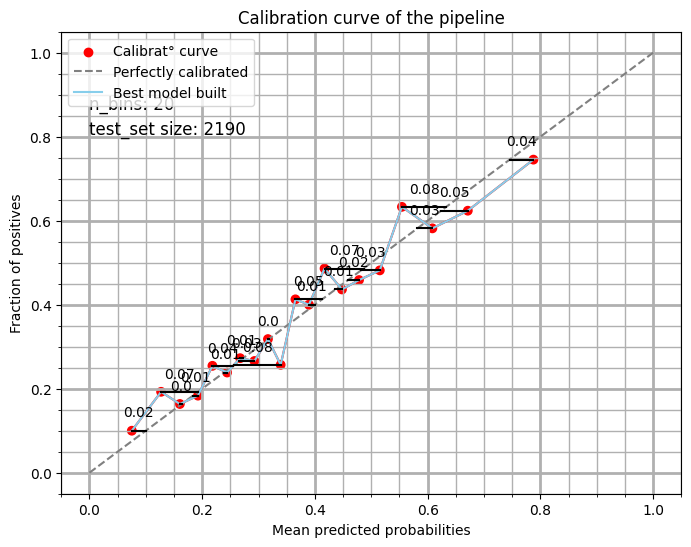

Above learning curve statistics on bins:

╒════╤════════════════╤═════════════════════════════╕
│    │ Bin interval   │   Predictions nb in the bin │
╞════╪════════════════╪═════════════════════════════╡
│  0 │ [0.02, 0.11]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  1 │ [0.11, 0.15]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  2 │ [0.15, 0.18]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  3 │ [0.18, 0.21]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  4 │ [0.21, 0.23]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  5 │ [0.23, 0.25]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  6 │ [0.25, 0.28]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  7 │ [0.28, 0.3]    │                 

In [12]:
#src.pipeline.results

from sklearn.base import clone

from pipeline import results

# On récupère la pipeline avec ses parametres optimaux 
chosen_pipeline = grid_search.best_estimator_

# We print the results of GridSearchCV() execution
print(chosen_pipeline)
results.GridSearchCV_results(grid_search, X_train_00.copy())


# Plot Calibration curve for the pipeline build by GridSearchCV
test_seasons = [2021,2022,2023,2024]

# Make proba predictions retraining the pipeline at every Game Week or every Season on test_seasons:
proba_predicted_GW_training, Y_test_GW_training, X_info_test_GW_training = results.proba_prediction_retrained_each_seas(X, Y, X_info, clone(chosen_pipeline), 'season', test_seasons)

#Plot Calibration curve of the pipeline and info about its bins
prob_pred_01, prob_true_01 = results.plot_calibration_curve_2(
                                Y_test_0 = Y_test_GW_training.copy(),
                                X_train_0 = X_info_test_GW_training.copy(),
                                proba_pred_0 = proba_predicted_GW_training.copy(),
                                n_bins_0 = 20,
                                strategy_0 = 'quantile',
                                color_0 = 'red',
                                GW_training_or_not = True,
                                )

#We display statistics on the pipeline probabilities deviation 
results.print_calibration_stats(prob_pred_01.copy(),
                                prob_true_01.copy(),
                                'non calibrated')


<span style="color:#FF1493;"> <strong> <font size="4">5) Pipeline and dataframes Saving


In [13]:
#src.pipeline.model

# If we consider that the pipeline obtained through GridSearchCV is promising and warrants further evaluation, we save it with the status 'under testing'.
# It will then be loaded in the `pipeline_test.ipynb` notebook for additional testing. Based on the results, we may decide to finalize and save it under the 'chosen' or 'best' status.


from pipeline import model
from features.features_selection import restricted_datasets


#On récupère la pipeline avec ses parametres optimaux 
under_testing_pipeline = grid_search.best_estimator_
under_testing_pipeline_trained = chosen_pipeline.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())

# Save the pipeline
model.save_pipeline(under_testing_pipeline_trained, "under_testing_pipeline_trained")


Successfully deleted the old pipeline:     under_testing_pipeline_trained
Successfully saved the new pipeline:       under_testing_pipeline_trained


